# Using NCEI geoportal REST API to collect information about IOOS Regional Association archived data

by Mathew Biddle, Faculty Specialist, UMD/ESSIC/CICS at the NOAA National Centers for Environmental Information (NCEI)

### IOOS regional associations archive their non-federal observational data with NOAA's National Center for Environmental Information (NCEI). In this notebook we will use the [RESTful](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) services of the [NCEI geoportal](https://www.nodc.noaa.gov/archivesearch/catalog/search/search.page) to collect metadata from the Archival Information Packages found in the NCEI archives. The metadata information are stored in [ISO 19115-2](https://wiki.earthdata.nasa.gov/display/NASAISO/ISO+19115-2) xml files which the NCEI geoportal uses for discovery of Archival Information Packages (AIPs). This example uses the ISO metadata records to display publication information as well as plot the time coverage of each AIP at NCEI which meets the search criteria.

First we import the owslib and numpy package. This allows us to parse the ISO xml records and process the information we gather.

Initialize a counter for plotting and a list to collect the NCEI Accession identifiers (we use this in the plotting routine). Also, update the namespaces dictionary from owslib to include the appropriate namespace reference for gmi and gml. 

For more information on ISO Namespaces see:  https://geo-ide.noaa.gov/wiki/index.php?title=ISO_Namespaces

In [1]:
from owslib.iso import namespaces

# Append gmi namespace to namespaces dictionary.
namespaces.update({"gmi": "http://www.isotc211.org/2005/gmi"})
namespaces.update({"gml": "http://www.opengis.net/gml/3.2"})

ModuleNotFoundError: No module named 'owslib'

### Now we select a Regional Association 
This is where the user identifies the Regional Association they are interested in. Simply uncomment the line that identifies the region of interest. The user can also omit the Regional Association to collect metadata information about all IOOS non-Federal observation data archived through the NCEI-IOOS pipeline.

In [2]:
# Select RA

RAs = {
    "GLOS": "Great Lakes Observing System",
    "SCCOOS": "Southern California Coastal Ocean Observing System",
    "SECOORA": "Southeast Coastal Ocean Observing Regional Association",
    "PacIOOS": "Pacific Islands Ocean Observing System",
    "NANOOS": "Northwest Association of Networked Ocean Observing Systems",
}

ra = RAs["SCCOOS"]

### Next we generate a geoportal query and georss feed
To find more information about how to compile a geoportal query, have a look at [REST API Syntax](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) and the [NCEI Search Tips](https://www.nodc.noaa.gov/search/granule/catalog/searchtips/searchtips.page) for the [NCEI geoportal](https://data.nodc.noaa.gov/geoportal/catalog/search/search.page). The example provided is specific to the NCEI-IOOS data pipeline project and only searches for non-federal timeseries data collected by each Regional Association. 

The query developed here can be updated to search for any Archival Information Packages at NCEI, therefore the user should develop the appropriate query using the [NCEI Geoportal](https://data.nodc.noaa.gov/geoportal/catalog/search/search.page) and update this portion of the code to identify the REST API of interest.

In [3]:
try:
    from urllib.parse import quote
except ImportError:
    from urllib import quote

# Generate geoportal query and georss feed.

# Base geoportal url.
baseurl = "https://data.nodc.noaa.gov/" "geoportal/rest/find/document" "?searchText="

# Identify the project.
project = (
    "dataThemeprojects:"
    '"Integrated Ocean Observing System '
    'Data Assembly Centers Data Stewardship Program"'
)

# Identify the Regional Association
ra = ' AND "{}" '.format(ra)

# Identify the platform.
platform = 'AND "FIXED PLATFORM"'

# Identify the amount of records and format of the response: 1 to 1010 records.
records = "&start=1&max=1010"

# Identify the format of the response: georss.
response_format = "&f=georss"

# Combine the URL.
url = "{}{}".format(baseurl, quote(project + ra + platform) + records + response_format)

print("Identified response format:\n{}".format(url))
print(
    "\nSearch page response:\n{}".format(url.replace(response_format, "&f=searchPage"))
)

Identified response format:
https://data.nodc.noaa.gov/geoportal/rest/find/document?searchText=dataThemeprojects%3A%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22%20AND%20%22Southern%20California%20Coastal%20Ocean%20Observing%20System%22%20AND%20%22FIXED%20PLATFORM%22&start=1&max=1010&f=georss

Search page response:
https://data.nodc.noaa.gov/geoportal/rest/find/document?searchText=dataThemeprojects%3A%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22%20AND%20%22Southern%20California%20Coastal%20Ocean%20Observing%20System%22%20AND%20%22FIXED%20PLATFORM%22&start=1&max=1010&f=searchPage


### Time to query the portal and parse out the georrs response
Here we are opening the specified REST API and parsing it into a string. Then, since we identified it as a georss xml format above, we parse it using the etree package. We then pull out all the ISO metadata record links and print them out so the user can browse to the metadata record and look for what items they might be interested in.

In [4]:
# Query the NCEI Geoportal and parse the georss response.

from lxml import etree

try:
    from urllib.request import urlopen
except ImportError:
    from urllib import urlopen

f = urlopen(url)  # Open georss response.
url_string = f.read()  # Read response into string.

# Create etree object from georss response.
url_root = etree.fromstring(url_string)
# Find all iso record links.
iso_record = url_root.findall("channel/item/link")
print("Found %i records" % len(iso_record))
for item in iso_record:
    print(item.text)  # URL to ISO19115-2 record.

Found 4 records
https://data.nodc.noaa.gov/geoportal/rest/document?id=%7B39551FC8-BFF1-48A6-9250-18B02A6AC9C6%7D
https://data.nodc.noaa.gov/geoportal/rest/document?id=%7B5EBDCCAB-E9ED-4C9D-A3FF-99EB69042DA0%7D
https://data.nodc.noaa.gov/geoportal/rest/document?id=%7B18120F26-D96D-4677-8DF8-0A5A8D79EC1B%7D
https://data.nodc.noaa.gov/geoportal/rest/document?id=%7BED88A565-52E1-43EF-9C48-F8FAA377107E%7D


### Lets plot up what we have found
Now that we have all the ISO metadata records we are interested in, it's time to do something fun with them. In this example we want to generate a timeseries plot of the data coverage for the "Southern California Coastal Ocean Observing System" stations we have archived at NCEI.

First we set up the figure and import some modules to facilitate plotting and string parsing.

Next, we loop through each iso record to collect metadata information about each package. The example here shows how to collect the following items:
   1. NCEI Archival Information Package (AIP) Accession ID (7-digit Accession Number) 
   2. The first date the archive package was published.
   3. The platform code identified from the provider.
   4. The version number and date it was published.
   5. The current AIP size, in MB.
   6. The bounding time, for each AIP found.

There are plenty of other metadata elements to collect from the ISO records, so we recommend browsing to one of the records and having a look at the items of interest to your community.

Then, the process plots each AIP as a timeseries showing the time coverage. 

Accession Number = 0157035
First published date = 2016-11-23
NCEI Accession 0157035 v1.1 = 
NCEI Accession 0157035 v2.2 = 
NCEI Accession 0157035 v3.3 = 
Current AIP Size = 52.084 MB
Bounding Time = 2005-06-16 TO 2016-12-31

Accession Number = 0157036
First published date = 2016-11-23
NCEI Accession 0157036 v1.1 = 
NCEI Accession 0157036 v2.2 = 
NCEI Accession 0157036 v3.3 = 
Current AIP Size = 48 MB
Bounding Time = 2005-09-16 TO 2016-12-31

Accession Number = 0157016
First published date = 2016-11-22
NCEI Accession 0157016 v1.1 = 
NCEI Accession 0157016 v2.2 = 
Current AIP Size = 52.208 MB
Bounding Time = 2005-06-16 TO 2015-07-13

Accession Number = 0157034
First published date = 2016-11-23
NCEI Accession 0157034 v1.1 = 
NCEI Accession 0157034 v2.2 = 
NCEI Accession 0157034 v3.3 = 
Current AIP Size = 89.956 MB
Bounding Time = 2005-06-16 TO 2016-12-31



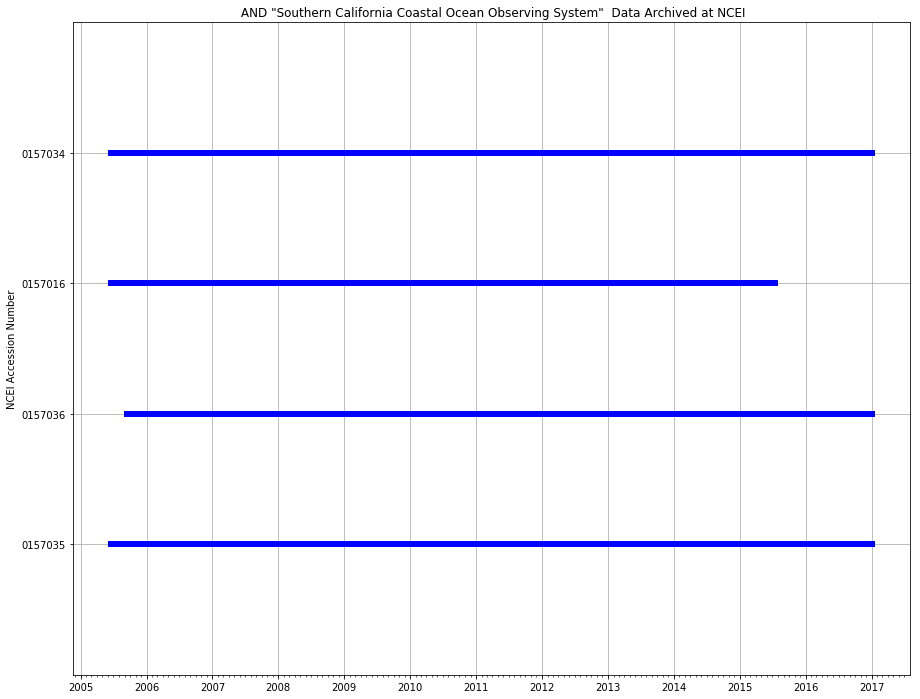

In [5]:
# Process each iso record.
%matplotlib inline

import re
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from owslib import util

fig, ax = plt.subplots(figsize=(15, 12))

i = 0
accenos = []

# For each accession in geo.rss response.
for item in iso_record:
    # Opens the iso xml web reference.
    iso_url = urlopen(item.text)
    # Creates tree element.
    iso_tree = etree.ElementTree(file=urlopen(item.text))
    # Gets the root from tree element.
    root = iso_tree.getroot()
    # Pulls out identifier string.
    ident = root.find(
        util.nspath_eval("gmd:fileIdentifier/gco:CharacterString", namespaces)
    )
    # Pulls out 7-digit accession number from identifier.
    acce = re.search("[0-9]{7}", util.testXMLValue(ident))
    # Adds accession number to accenos list.
    accenos.append(acce.group(0))
    print("Accession Number = %s" % acce.group(0))

    # Collect Publication date information.
    date_path = (
        "gmd:identificationInfo/"
        "gmd:MD_DataIdentification/"
        "gmd:citation/"
        "gmd:CI_Citation/"
        "gmd:date/"
        "gmd:CI_Date/"
        "gmd:date/gco:Date"
    )
    # First published date.
    pubdate = root.find(util.nspath_eval(date_path, namespaces))
    print("First published date = %s" % util.testXMLValue(pubdate))

    # Collect Provider Platform Codes (if it has it).
    for tag in root.getiterator(util.nspath_eval("gco:CharacterString", namespaces)):
        if tag.text == "Provider Platform Codes":
            # Backs up to the MD_keywords element.
            node = tag.getparent().getparent().getparent().getparent()
            for item in node.findall(
                util.nspath_eval("gmd:keyword/gco:CharacterString", namespaces)
            ):
                print("Provider Platform Code = %s" % item.text)

    # Pull out the version information.
    # Iterate through each processing step which is an NCEI version.
    for tag in root.getiterator(util.nspath_eval("gmd:processStep", namespaces)):
        # Only parse gco:DateTime and gmd:title/gco:CharacterString.
        vers_title = (
            "gmi:LE_ProcessStep/"
            "gmi:output/"
            "gmi:LE_Source/"
            "gmd:sourceCitation/"
            "gmd:CI_Citation/"
            "gmd:title/gco:CharacterString"
        )
        vers_date = "gmi:LE_ProcessStep/" "gmd:dateTime/gco:DateTime"
        if tag.findall(util.nspath_eval(vers_date, namespaces)) and tag.findall(
            util.nspath_eval(vers_title, namespaces)
        ):
            # Extract dateTime for each version.
            datetimes = tag.findall(util.nspath_eval(vers_date, namespaces))
            # Extract title string (contains version number).
            titles = tag.findall(util.nspath_eval(vers_title, namespaces))
            print(
                "{} = ".format(
                    util.testXMLValue(titles[0]), util.testXMLValue(datetimes[0])
                )
            )

    # Collect package size information.
    # Iterate through transfersize nodes.
    for tag in root.getiterator(util.nspath_eval("gmd:transferSize", namespaces)):
        # Only go into first gco:Real (where size exists).
        if tag.find(util.nspath_eval("gco:Real", namespaces)).text:
            # Extract size.
            sizes = tag.find(util.nspath_eval("gco:Real", namespaces))
            print("Current AIP Size = %s MB" % sizes.text)
            break
        # Only use first size instance, all gco:Real attributes are the same.
        break

    # Bounding time for AIP.
    for tag in root.getiterator(util.nspath_eval("gml:TimePeriod", namespaces)):
        # If text exists in begin or end position nodes.
        if (
            tag.find(util.nspath_eval("gml:beginPosition", namespaces)).text
            and tag.find(util.nspath_eval("gml:endPosition", namespaces)).text
        ):
            start_date = tag.find(
                util.nspath_eval("gml:beginPosition", namespaces)
            ).text
            end_date = tag.find(util.nspath_eval("gml:endPosition", namespaces)).text
    print("Bounding Time = %s TO %s\n" % (start_date, end_date))

    # Plotting routine for each accession, plot start-end as timeseries for each accession.
    # Create datetime objects for start_date and end_date.
    date1 = datetime(
        int(start_date.split("-")[0]),
        int(start_date.split("-")[1]),
        int(start_date.split("-")[2]),
    )
    date2 = datetime(
        int(end_date.split("-")[0]),
        int(end_date.split("-")[1]),
        int(end_date.split("-")[2]),
    )
    dates = [date1, date2]
    i += 1  # Counter for plotting.
    y = [i, i]
    # Plot the timeseries.
    ax.plot_date(x=dates, y=y, fmt="-", color="b", linewidth=6.0)

# Clean up the plot.
ax.set_ylim([0, i + 1])
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter("%Y")
ax.xaxis.grid(True)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)  # Format the xaxis labels.
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.grid(True)
ax.set(yticks=np.arange(1, len(accenos) + 1))
ax.tick_params(which="both", direction="out")
ax.set_yticklabels(accenos)
plt.ylabel("NCEI Accession Number")
title = ax.set_title("%s Data Archived at NCEI" % ra)

This procedure has been developed as an example of how to use NCEI's geoportal REST API's to collect information about packages that have been archived at NCEI. The intention is to provide some guidance and ways to collect this information without having to request it directly from NCEI. There are a significant amount of metadata elements which NCEI makes available through their ISO metadata records. Therefore, anyone interested in collecting other information from the records at NCEI should have a look at the ISO metadata records and determine which items are of interest to their community. Then, update the example code provided to collect that information.
